# Multi-input GAN
Experiment on multi-input GAN with mnist and fashion mnist dataset

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# Load MNIST and Fashion MNIST datasets
(x_train_mnist, _), (_, _) = mnist.load_data()
(x_train_fashion, _), (_, _) = fashion_mnist.load_data()

# Preprocess the datasets
x_train_mnist = (x_train_mnist.astype(np.float32) - 127.5) / 127.5
x_train_fashion = (x_train_fashion.astype(np.float32) - 127.5) / 127.5

x_train_mnist = np.expand_dims(x_train_mnist, axis=-1)
x_train_fashion = np.expand_dims(x_train_fashion, axis=-1)

4422102/4422102 [==============================] - 1s 0us/step


In [3]:
def build_generator():
    # MNIST input
    input_mnist = Input(shape=(100,))
    x_mnist = Dense(128 * 7 * 7, activation="relu")(input_mnist)
    x_mnist = Reshape((7, 7, 128))(x_mnist)
    x_mnist = BatchNormalization()(x_mnist)
    x_mnist = UpSampling2D()(x_mnist)
    x_mnist = Conv2D(128, kernel_size=3, padding="same")(x_mnist)
    x_mnist = Activation("relu")(x_mnist)
    x_mnist = BatchNormalization()(x_mnist)
    x_mnist = UpSampling2D()(x_mnist)
    x_mnist = Conv2D(64, kernel_size=3, padding="same")(x_mnist)
    x_mnist = Activation("relu")(x_mnist)
    x_mnist = BatchNormalization()(x_mnist)
    x_mnist = Conv2D(1, kernel_size=3, padding="same")(x_mnist)
    out_mnist = Activation("tanh")(x_mnist)

    # Fashion MNIST input
    input_fashion = Input(shape=(100,))
    x_fashion = Dense(128 * 7 * 7, activation="relu")(input_fashion)
    x_fashion = Reshape((7, 7, 128))(x_fashion)
    x_fashion = BatchNormalization()(x_fashion)
    x_fashion = UpSampling2D()(x_fashion)
    x_fashion = Conv2D(128, kernel_size=3, padding="same")(x_fashion)
    x_fashion = Activation("relu")(x_fashion)
    x_fashion = BatchNormalization()(x_fashion)
    x_fashion = UpSampling2D()(x_fashion)
    x_fashion = Conv2D(64, kernel_size=3, padding="same")(x_fashion)
    x_fashion = Activation("relu")(x_fashion)
    x_fashion = BatchNormalization()(x_fashion)
    x_fashion = Conv2D(1, kernel_size=3, padding="same")(x_fashion)
    out_fashion = Activation("tanh")(x_fashion)

    # Concatenate the outputs
    out_combined = Concatenate(axis=-1)([out_mnist, out_fashion])

    return Model(inputs=[input_mnist, input_fashion], outputs=out_combined)    

In [4]:
def build_discriminator():
    input_img = Input(shape=(28, 28, 2))

    x = Flatten()(input_img)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model(inputs=input_img, outputs=x)

In [9]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Build the generator
generator = build_generator()

In [10]:
# The generator takes two inputs: noise for MNIST and noise for Fashion MNIST
noise_mnist = Input(shape=(100,))
noise_fashion = Input(shape=(100,))
img = generator([noise_mnist, noise_fashion])

# For the combined model, we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model (stacked generator and discriminator)
combined = Model(inputs=[noise_mnist, noise_fashion], outputs=validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [11]:
def train(epochs, batch_size=128, save_interval=50):
    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        #  Train Discriminator

        # Select a random half batch of images from MNIST and Fashion MNIST
        idx_mnist = np.random.randint(0, x_train_mnist.shape[0], half_batch)
        idx_fashion = np.random.randint(0, x_train_fashion.shape[0], half_batch)
        imgs_mnist = x_train_mnist[idx_mnist]
        imgs_fashion = x_train_fashion[idx_fashion]

        # Generate a half batch of new images
        noise_mnist = np.random.normal(0, 1, (half_batch, 100))
        noise_fashion = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict([noise_mnist, noise_fashion])

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(np.concatenate([imgs_mnist, imgs_fashion], axis=-1), np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #  Train Generator

        noise_mnist = np.random.normal(0, 1, (batch_size, 100))
        noise_fashion = np.random.normal(0, 1, (batch_size, 100))

        # The generator wants the discriminator to label the generated samples as valid (ones)
        valid_y = np.array([1] * batch_size)
        # Train the generator
        g_loss = combined.train_on_batch([noise_mnist, noise_fashion], valid_y)

        # Print the progress
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")

        # If at save interval, save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)        

In [14]:
import matplotlib.pyplot as plt

def save_imgs(epoch):
    r, c = 5, 5
    noise_mnist = np.random.normal(0, 1, (r * c, 100))
    noise_fashion = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict([noise_mnist, noise_fashion])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(f"images/multi_input_gan_{epoch}.png")
    plt.close()

# Create output directory for generated images
import os
if not os.path.exists('images'):
    os.makedirs('images')

In [ ]:
train(epochs=30000, batch_size=32, save_interval=200)

流式输出内容被截断，只能显示最后 5000 行内容。
1/1 [==============================] - 0s 19ms/step
25221 [D loss: 0.7707850635051727, acc.: 46.875] [G loss: 0.775686502456665]
1/1 [==============================] - 0s 20ms/step
25222 [D loss: 0.6843845546245575, acc.: 53.125] [G loss: 0.7326632738113403]
1/1 [==============================] - 0s 19ms/step
25223 [D loss: 0.7321317791938782, acc.: 43.75] [G loss: 0.7889375686645508]
1/1 [==============================] - 0s 21ms/step
25224 [D loss: 0.6763206422328949, acc.: 62.5] [G loss: 0.7691943049430847]
1/1 [==============================] - 0s 27ms/step
25225 [D loss: 0.6626760959625244, acc.: 56.25] [G loss: 0.718478262424469]
1/1 [==============================] - 0s 23ms/step
25226 [D loss: 0.6620798408985138, acc.: 50.0] [G loss: 0.7917299270629883]
1/1 [==============================] - 0s 18ms/step
25227 [D loss: 0.7193396687507629, acc.: 43.75] [G loss: 0.7313779592514038]
1/1 [==============================] - 0s 20ms/step
25228 [D loss: 0.698

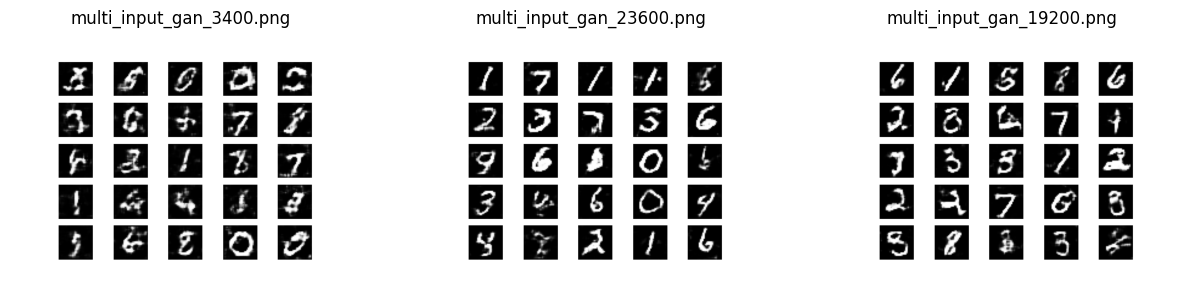

In [15]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt


image_dir = 'images'
image_files = os.listdir(image_dir)

# Randomly select 3 image files
selected_images = random.sample(image_files, 3)

# Display the selected images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, img_file in enumerate(selected_images):
    img = Image.open(os.path.join(image_dir, img_file))
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(img_file)

plt.show()